In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle


In [2]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_pca.h5')
X_pca = store['X_pca']

store = pd.HDFStore('X_mob.h5')
X_mob = store['X_mob']

store = pd.HDFStore('y_default.h5')
y_default = store['y_default']

store = pd.HDFStore('y_prepay.h5')
y_prepay = store['y_prepay']

X_pca = X_pca.join(X_mob)

In [3]:
X_pca_add = X_pca[X_pca['mob']>2].copy()
X_pca_add['mob'] = np.floor(X_pca_add['mob']/2)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [4]:
X_pca_add = X_pca[X_pca['mob']>4].copy()
X_pca_add['mob'] = np.ceil(X_pca_add['mob']/4*3)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [5]:
X_pca_add = X_pca[X_pca['mob']>4].copy()
X_pca_add['mob'] = np.floor(X_pca_add['mob']/4)
X_pca_add_half_sample = X_pca_add.sample(frac = 0.5)
X_pca = pd.concat([X_pca, X_pca_add_half_sample])

zeros = pd.DataFrame(np.zeros(X_pca_add_half_sample.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [7]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,mob,Orig_month,Orig_year
0,0.717521,-0.458524,1.433562,1.046494,0.164595,-0.072055,-0.030477,-0.168625,-0.026212,0.399204,-0.980749,45.0,4,2016
1,2.244616,-1.030425,-2.443468,-0.576140,0.748542,-0.115527,1.318192,0.025524,0.144284,-0.892829,0.537241,36.0,5,2016
2,0.310954,0.027425,-1.540056,0.840923,-0.836991,-0.101286,0.769092,0.116545,0.204194,-0.554330,0.878635,36.0,4,2016
3,0.383023,-1.832473,-0.242715,0.706981,-0.896038,0.766941,0.857497,0.164902,0.243484,-0.455246,1.471685,37.0,5,2016
4,2.691928,1.549250,1.128812,1.238563,-0.146378,0.364322,1.418887,-0.103755,0.294065,-0.282789,-1.066466,36.0,6,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338820,1.385782,-1.013195,0.961528,0.971565,-0.244169,-1.489593,-0.688910,0.130463,-0.227357,-0.167910,0.429469,3.0,11,2016
115384,-0.233503,1.542994,0.814158,0.910634,0.018829,0.165065,0.460301,-0.034804,0.106349,-0.302052,0.643648,2.0,12,2018
116963,-0.963520,-1.632283,-0.478931,1.388443,-0.532818,-0.441926,1.022165,0.041784,0.203051,-0.527137,0.223606,1.0,12,2018
257487,0.940869,1.710507,-2.817080,-0.978621,0.600631,-2.023841,-1.472404,0.122636,-0.446270,-0.205902,0.618418,9.0,9,2016


In [6]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_default, test_size=0.2, random_state=2)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.750


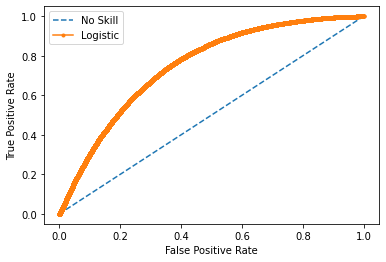

24.36419987678528 s


In [7]:
time_start = time.time()
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
time_end = time.time()

# save the model to disk
filename = 'lg_model_no_Time_default.sav'
#filename = 'lg_model_date_default.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

print (time_end - time_start, "s")

In [8]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.640


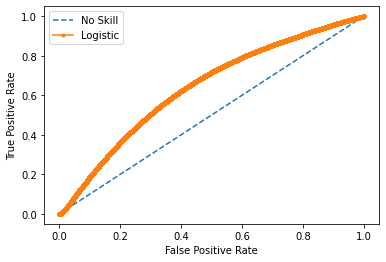

8.872956275939941 s


In [9]:
time_start = time.time()
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
time_end = time.time()

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only

filename = 'lg_model_no_Time_prepay.sav'
#filename = 'lg_model_date_prepay.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

print (time_end - time_start, "s")